# Creating the Historical Visualization

In this notebook, we build an animated, interactive choropleth with Plotly to visualize the data from Hubálek and Rudolf in our Dash application. We start by reading in the pickled DataFrame that we created in Historical_Data_Cleaning.ipnyb. We then format the "Description" column of the DataFrame to work with Plotly, and define a function that outputs our final visual. We also create a static image of our visual using Kaleido, a library developed by Plotly to export static images of plots. Kaleido typically needs to be installed separately from Plotly but does not require a separate import statement.

In [34]:
#!pip install kaleido
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import Image, display

### Reading In the Data

In [35]:
# Read in the DataFrame
df = pd.read_pickle("../data/processed/historical_outbreaks_df.pkl")

### Creating the Visual

Our goal with this visualization is to demonstrate the scale of the problem that zoonotic diseases pose to humanity. Our data is limited in that we do not have detailed, consistent, and accurate counts of total cases and health outcomes for each outbreak. But the data is interesting in that it is capable of telling a story throughout recorded human history of where and when outbreaks have occurred. Keep in mind that the descriptions of each event are from a summary from Hubálek and Rudolf, and that the data only includes outbreaks that have been recorded. Just because an area of the world did not record an outbreak in a given year does not necessarily mean that an outbreak did not occur.

To accomplish our goal, we plan to create an animated choropleth showing outbreaks over time with the following properties:
- encoded variables (expressiveness):
    - Country (political boundaries on map, hoverdata)
    - Outbreak Year (hoverdata, combination of color and current year)
    - Years Since the Outbreak (color, hoverdata)
    - Outbreak description (hoverdata)
- interactivity:
    - play/pause buttons for the animation
    - slider to manually select year
    - ability to adjust year range, past years shown, and animation speed when calling the function to create the visual. These arguments will be useful in our dash app.
- effectiveness:
    - clearly shows which countries are experiencing an outbreak in a given year
    - clearly shows which countries have experienced an outbreak in recent years
    - demonstrates the constant and global nature of the problem
    
    
We use a Jupyter magic command to write our function to a .py file to be used by our Dash app. If you want to update the function, uncomment the first lines of the next cell. With all of those things in mind, here is the function that generates our visual:

In [78]:
#%%writefile ../src/dash_app/generate_historical_viz.py
#import pandas as pd
#import plotly.express as px
#import plotly.graph_objects as go
#import ipywidgets as widgets
#from IPython.display import Image, display

def generate_historical_viz(df, start=1709, end=2010, past_years=50, country_name="Name", duration=500):
    
    # Handle potential errors
    assert start < end, "Start year must be before end year."
    assert past_years <= 50, "Maximum past years is 50."
    assert start >= -1800, "Minimum start year is -1800."
    assert end <= 2010, "Maximum end year is 2010."
    assert country_name in ["Name", "ISO-3"], "Only two options for country_name: 'Name' or 'ISO-3'."
    
    # Choose column for country name
    if country_name == "Name":
        name_col = "Country_Name"
    else:
        name_col = "Country"  
    
    # Filter the DataFrame
    df = df.loc[(df['Year']>=start) & (df['Year']<=end) & (df['Years_Since_Outbreak']<=past_years)]
    
    # Extract unique years
    years = df['Year'].unique()

    # Create a template for hover data
    hover_temp = 'Country: %{customdata[0]}<br>Outbreak Year: %{customdata[1]}<br>Years\
    Since Outbreak: %{customdata[2]}<br><br>Description:<br>%{customdata[3]}\
    <extra></extra>'

    # Create a list to store frames
    frames = []

    # Create frames for each year
    for year in years:
        filtered_df = df[df['Year'] == year]
        frame = go.Frame(data=[
            go.Choropleth(
                locations=filtered_df['Country'],
                locationmode='ISO-3',
                z=filtered_df['Years_Since_Outbreak'], # z is used to determine color in Plotly
                colorscale = px.colors.sequential.Reds_r,
                colorbar_title='Years Since<br>Outbreak',
                customdata = filtered_df[[name_col, 'Outbreak_Year', 'Years_Since_Outbreak', 'Text']],
                hovertemplate=hover_temp,
                zmin=0, # set the range for z
                zmax=past_years, # allow range to change depending on function inputs
                colorbar = dict(
                    bgcolor='white',
                    x=.03,
                    y=.1,
                    xanchor='left',
                    yanchor='bottom',
                    len=.45,
                    bordercolor='black',
                    borderwidth=1,    
                ), 
            )
        ],
            name=f'Frame {year}'
        )
        frames.append(frame)

    # Create the initial choropleth map
    fig = go.Figure(data=[
        go.Choropleth(
            locations=df.loc[df['Year']==df['Year'].min()]['Country'],
            locationmode='ISO-3',
            z=df['Years_Since_Outbreak'],
            colorscale=px.colors.sequential.Reds_r,
            colorbar_title='Years Since<br>Outbreak',
            customdata = df[[name_col, 'Outbreak_Year', 'Years_Since_Outbreak', 'Text']],
            hovertemplate=hover_temp,
            zmin=0, 
            zmax=past_years, 
            colorbar = dict(
                    bgcolor='white',
                    x=.03,
                    y=.1,
                    xanchor='left',
                    yanchor='bottom',
                    len=.45,
                    bordercolor='black',
                    borderwidth=1,
                    outlinewidth=.5,
                    outlinecolor='black',
                    nticks=10,
                    ticks='outside',
                ), 
        )
    ])

    # Add frames to the figure
    fig.frames = frames

    # Select map version
    fig.update_geos(
        showcountries=True,
        countrywidth=.3,
        landcolor='#B8E7FF',
    )

    # Update layout properties
    fig.update_layout(
        title_text=f"Countries Experiencing Zoonotic Outbreaks by Year: {start} - {end}",
        title_font_size=24,
        title_x=.5,
        title_y=.89,
        height=600,
        width=1000,

        # Add buttons to interact with
        updatemenus=[{
            'type': 'buttons',
            'x': .08,
            'y': -.025,
            'showactive': True,
            'buttons': [{
                'label': 'Play',
                'method': 'animate',
                'args': [None, {
                    'fromcurrent': True,
                    'frame': {'duration': duration, 'redraw': True}, # allow for custom duration
                    'transition': {'duration': 300, 'easing': 'quadratic-in-out'}
                }]
            }, {
                'label': 'Pause',
                'method': 'animate',
                'args': [[None], {
                    'frame': {'duration': 0, 'redraw': True},
                    'mode': 'immediate',
                    'transition': {'duration': 0}
                }]
            }]
        }],

        # Add the year slider
        sliders=[{
            'active': 0,
            'yanchor': 'top',
            'xanchor': 'left',
            'currentvalue': {
                'font': {'size': 20},
                'prefix': 'Current Year:',
                'visible': True,
                'xanchor': 'right'
            },
            'transition': {'duration': 300, 'easing': 'cubic-in-out'},
            'pad': {'b': 0, 't': 0},
            'len': 0.9,
            'x': 0.1,
            'y': 0.00,
            'steps': [{
                'args': [[f'Frame {year}'], {
                    'frame': {'duration': 300, 'redraw': True},
                    'mode': 'immediate',
                    'transition': {'duration': 300}
                }],
                'label': f' {year}',
                'method': 'animate'
            } for year in years]
        }],
        
    )
    
    # Add a hyperlink containing source of the data
    source_text = 'Source: <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7120709/">\
    Hubálek and Rudolf, National Library of Medicine, 2010</a>'
    fig.add_annotation(
        text=source_text,
        showarrow=False,
        xref='paper', # 'paper' sets the value of x to a fraction of the plotting area rather than a coordinate
        yref='paper', # do the same for y
        x=0.9, 
        y=0.02,  
        font=dict(size=10, color='gray'),
    )

    return fig

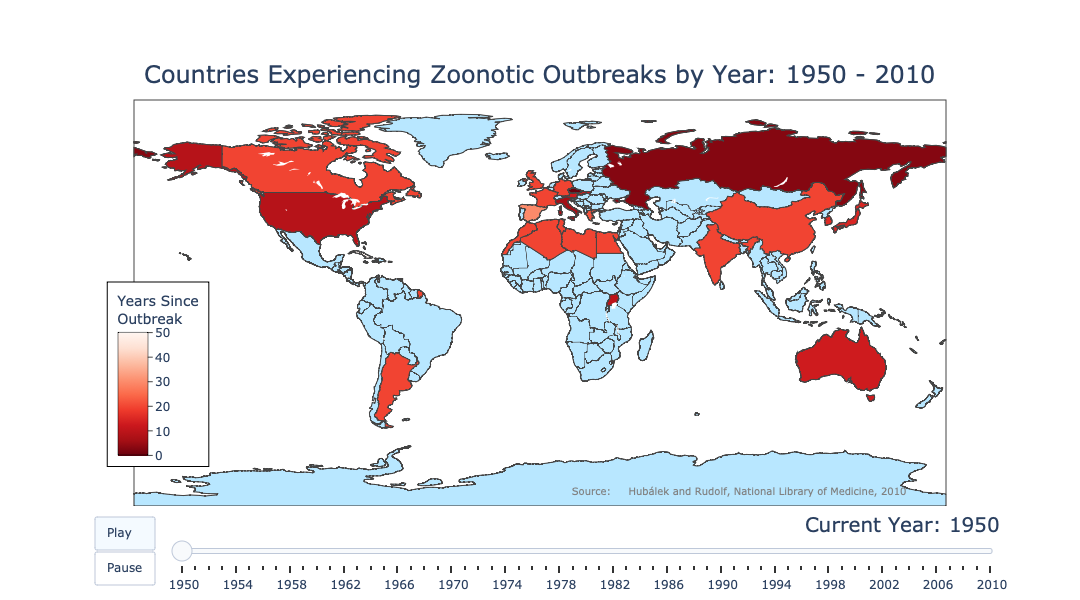

In [79]:
generate_historical_viz(df, 1950, 2010)

### Viewing a Static Image (No Mouseover Data):

If running the previous cell did not generate the visual, run the next one to view it as a static image. You can uncomment the code in the next cell to play with the function parameters and view different versions of the visual.

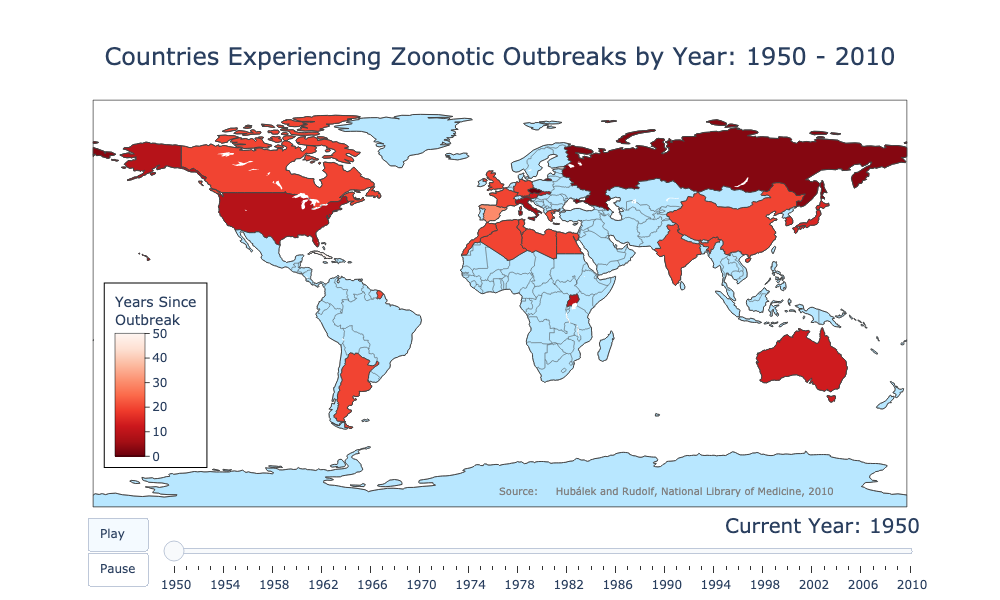

In [63]:
# Uncomment the first line to generate a figure. Uncomment the second line to update the displayed visual with the new figure.

fig = generate_historical_viz(df, start=1950, end=2010, past_years=50)
fig.write_image('../images/static_historical_visual.png')
Image(filename='../images/static_historical_visual.png')

### Conclusion and Ethical Considerations
Our visualization accomplishes our goal of demonstrating the nature and scale of the problem of zoonotic outbreaks throughout history. However, it is incredibly important to understand the limitations of the data that we used to create it. Many countries are not mentioned at all in the story told by Hubálek and Rudolf - a result of either a lack of reporting and record keeping or their own biases, but certainly not a lack of outbreaks. It is easy to watch our animation and assume that outbreaks are primarily a problem in Europe, Asia, and North America. Our worry is that this will lead observers to conclude that our efforts to combat them should be directed towards those areas of the world, when in reality areas under-represented in the data, such as Sub-Saharan Africa and Southeast Asia, are more in-need of help. In the future, it would be great to incorporate more complete data that includes case counts, deaths, how each multi-country outbreak spread, and more outbreaks representing more countries. Still, thank you for reading our work and we hope you enjoyed and learned something from our visualization.